In [1]:
def print_tags(tokens, attribute, palette='Set2', with_tags=True, return_html=False):
    
    filter_out = ['PUNCT', "", " ", None]
    style = """background: {}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;"""
    tag_style = """font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; 
                    text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem;"""
    bare_style = """line-height: 2.5; direction: ltr;"""
    if not attribute.endswith('_'):
        attribute+='_'
        #color:{pal[n]}; 
        
    attribs = np.unique([getattr(t, attribute) for t in tokens])
    pal = sns.palettes.color_palette(palette, n_colors=len(attribs)).as_hex()
    
    stng = f'<p style="{bare_style}">'
    for i, token in enumerate(tokens):
        if (str(token) not in string.punctuation) or (i==0):
            stng = stng+ " "
        color = pal[np.where(attribs==getattr(token, attribute))[0][0]]
        
        if with_tags and getattr(token, attribute) not in filter_out:
            stng = stng + f'<text style="{style.format(color)}">'
            stng = stng + f'{token.text} <text style="{tag_style}">{getattr(token, attribute)}' +'</text></text>'
        elif getattr(token, attribute) in filter_out:
            stng = stng + f'<text style="{bare_style}">{token} </text>'
        else:
            stng = stng + f'<text style="{style.format(color)}">{token} </text>'
    if not with_tags:
        
        stng +=f'</p><p style="{bare_style}">LEGEND:</p><p style="{bare_style}">'
        for i, p in enumerate(attribs):
            if p not in filter_out:
                stng = stng + f'<text style="{style.format(pal[i])}">{spacy.explain(p)}: <text style="{tag_style}">{p} </text></text>'
    stng += '</p>'
    if return_html:
        return stng
    else:
        return display.HTML(stng)

class topic:
    def __init__(self, word, perc):
        self.word = word
        self.text = str(word)
        self.perc = perc
        self.perc_ = str(perc)
        
    def __repr__(self):
        return self.word
    
    

In [2]:
import spacy
import numpy as np
import pandas as pd
import gensim
import tqdm
import seaborn as sns
import string
from IPython import display
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

# Natural Language Processing -- Part 2

Now that we have some basics of text processing, and retrieving basic information such as named entities and part-of-speech tags, we can look into more advanced modelling for information retreival.

To be able to use modelling to extract meaning and information from text, you need a numerical representation of your texts. So we transform our words to vectors.

### One hot encoding

The simpelest way of making a vector representation is by using one-hot ecoding. In one hot encoding you give a number to each unique word you have in your corpus.

For example, let's say my entire dataset consist of these two sentences:

In [3]:
sentences = ["We will stick to natural language processing in this class",
             "Bert found a stick in the forest"]

In [4]:
words = [w.lower() for sentence in sentences for w in sentence.split(' ')]
words = list(np.unique(words))
words.sort()
print(len(words),'unique words')
words

15 unique words


['a',
 'bert',
 'class',
 'forest',
 'found',
 'in',
 'language',
 'natural',
 'processing',
 'stick',
 'the',
 'this',
 'to',
 'we',
 'will']

In [5]:
# I can give each of these words a number
word_index ={}
for i, w in enumerate(words):
    word_index[w] = i
    print(w, ':', i)

a : 0
bert : 1
class : 2
forest : 3
found : 4
in : 5
language : 6
natural : 7
processing : 8
stick : 9
the : 10
this : 11
to : 12
we : 13
will : 14


Each of these words now has a one-hot encoded represenation, which are vectors that are **13** zeros, with **one** 1, at the index of the word. So, Bert would have:

In [6]:
v_bert = np.zeros((len(words),)).astype(int)
v_bert[word_index['bert']] = 1
v_bert

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

And for language it would be:

In [7]:
v_lang = np.zeros((len(words),)).astype(int)
v_lang[word_index['language']] = 1
v_lang

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

We an also use this method to create a representation of our sentences. 

In [8]:
vectors = []
for sentence in sentences:
    vector = np.zeros((len(words), )).astype(int)
    idx = [word_index[w.lower()] for w in sentence.split(' ')]
    vector[idx] = 1
    vectors.append(vector)
    print(sentence)
    print('\t', vector)
    print()

We will stick to natural language processing in this class
	 [0 0 1 0 0 1 1 1 1 1 0 1 1 1 1]

Bert found a stick in the forest
	 [1 1 0 1 1 1 0 0 0 1 1 0 0 0 0]



Stacking these into a matrix, is called a document term count. The 'documents' are then the sentences. This is called a **Document Term Matrix** (DTM) or **Document Term Count** (DTC).

In [9]:
np.stack(vectors)

array([[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

Obviously this is a small dataset, so the 'matrix' is tiny. In addtition the name *Docment Term Count* implies that it shows a count of the number of words. SInce our example sentences (or documents) only have unique words in them, the count is always one. So let's look at a larged dataset.

Luckly, we can use different pre existing python packages to create a document term matrix, without doing all the manual steps like we did above.
For this example I will be using scikit-learn (sklearn) and nltk.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

In [11]:
# Grab an example dataset of old newsgroups
newsgroups = fetch_20newsgroups()
print(newsgroups.data[0])
print(f"There are {len(newsgroups.data)} newsgroup postings in this dataset")

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





There are 11314 newsgroup postings in this dataset


We now use the `CountVectorizer` from sklearn to create a *DTC*. To ensure that we don't create a giant matrix, and we only want relevant words we use some techniques from the previous section as preprocessig steps:
 - We filter out stopwords
 - We set a minumum word count per document to no lower than 2
 - We set a maximum appearance of a word to 90% of all documents
 - We stem our words to combine different conjugations

In [12]:
# Define the stemmer
stemmer = SnowballStemmer(language='english')
# Define a list of stopwords. Note we need to stem these as well!
input_stopwords = [stemmer.stem(w) for w in stopwords.words('english')]
# Define the vectorizer
vectorizer = CountVectorizer(preprocessor=stemmer.stem, stop_words=input_stopwords, min_df=2, 
                             max_df=0.9,
                            token_pattern=r"[a-zA-Z]{2,}")

In [13]:
dtc = vectorizer.fit_transform(newsgroups.data)
print(len(newsgroups.data))
dtc.shape

11314


(11314, 46689)

In [14]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaaarrgghhhh',
 'aaah',
 'aaahhhh',
 'aachen',
 'aad',
 'aaf',
 'aaldoubo',
 'aam',
 'aamir',
 'aammmaaaazzzzzziinnnnggggg',
 'aamrl',
 'aantal',
 'aao',
 'aardvark',
 'aargh',
 'aarghhhh',
 'aarhus',
 'aario',
 'aarnet',
 'aaron',
 'aaronc',
 'aas',
 'aatchoo',
 'aau',
 'aauwpiugyv',
 'aav',
 'aaw',
 'ab',
 'ababs',
 'abacus',
 'abad',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abate',
 'abberation',
 'abbey',
 'abbot',
 'abbott',
 'abbreviation',
 'abbreviations',
 'abc',
 'abcd',
 'abcdefghijklmnopqrstuvwxyz',
 'abd',
 'abdel',
 'abdkw',
 'abdomen',
 'abdominal',
 'abduction',
 'abdul',
 'abdullah',
 'abed',
 'abel',
 'aben',
 'aber',
 'aberdeen',
 'aberrant',
 'aberration',
 'aberystwyth',
 'abetter',
 'abg',
 'abh',
 'abhin',
 'abhor',
 'abhorent',
 'abhorrent',
 'abide',
 'abiding',
 'abilities',
 'ability',
 'abingdon',
 'abiogenesis',
 'ablaze',
 'able',
 'ably',
 'abner',
 'abnormal',
 'abnormalities',
 'abo',
 'aboard',
 'abode',
 'abolish',
 

In [15]:
doc_nr = 0

words = np.array(vectorizer.get_feature_names())[dtc.toarray()[doc_nr, :]>1]
counts = dtc.toarray()[doc_nr, :][dtc.toarray()[doc_nr, :]>1]
for i, word in enumerate(words):
    print(word, counts[i])

anyone 2
car 5
edu 2
lerxst 2
umd 2
wam 2


In [16]:
newsgroups.data[doc_nr]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

similar = cosine_similarity(dtc)

sim_dtc = similar[0, :].argsort()[::-1][:20]

df_dtc = pd.DataFrame(dtc[sim_dtc, :].toarray())
df_dtc[df_dtc==0] = float('nan')
df_dtc = df_dtc.dropna(axis=1, how='all')
df_dtc.columns = np.array(vectorizer.get_feature_names())[df_dtc.columns.values]
df_dtc.index = sim_dtc
most_common = df_dtc.sum(0).sort_values(ascending=False)[:20].index.values
df_dtc = df_dtc.loc[:, most_common]

<Figure size 1440x576 with 0 Axes>

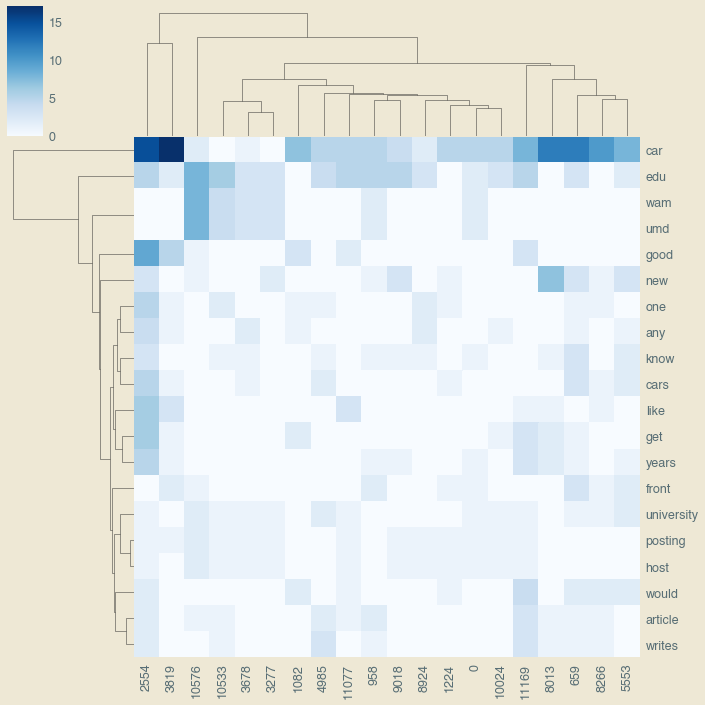

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
sns.clustermap(df_dtc.fillna(0).T, cmap='Blues')

### TFIDF

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

source <a href='http://www.tfidf.com/'>tfidf.com</a>

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Define the stemmer
stemmer = SnowballStemmer(language='english')
# Define a list of stopwords. Note we need to stem these as well!
input_stopwords = [stemmer.stem(w) for w in stopwords.words('english')]
# Define the vectorizer
vectorizer = TfidfVectorizer(preprocessor=stemmer.stem, stop_words=input_stopwords, min_df=2, 
                             max_df=0.9,
                            token_pattern=r"[a-zA-Z]{2,}")

In [20]:
tfidf = vectorizer.fit_transform(newsgroups.data)
print(len(newsgroups.data))
tfidf.shape

11314


(11314, 46689)

In [21]:
similar = cosine_similarity(tfidf)

sim_tfidf = similar[0, :].argsort()[::-1][:20]

df_tfidf = pd.DataFrame(tfidf[sim_tfidf, :].toarray())
df_tfidf[df_tfidf==0] = float('nan')
df_tfidf = df_tfidf.dropna(axis=1, how='all')
df_tfidf.columns = np.array(vectorizer.get_feature_names())[df_tfidf.columns.values]
df_tfidf.index = sim_tfidf
most_common = df_tfidf.sum(0).sort_values(ascending=False)[:20].index.values
df_tfidf = df_tfidf.loc[:, most_common]

<Figure size 1440x576 with 0 Axes>

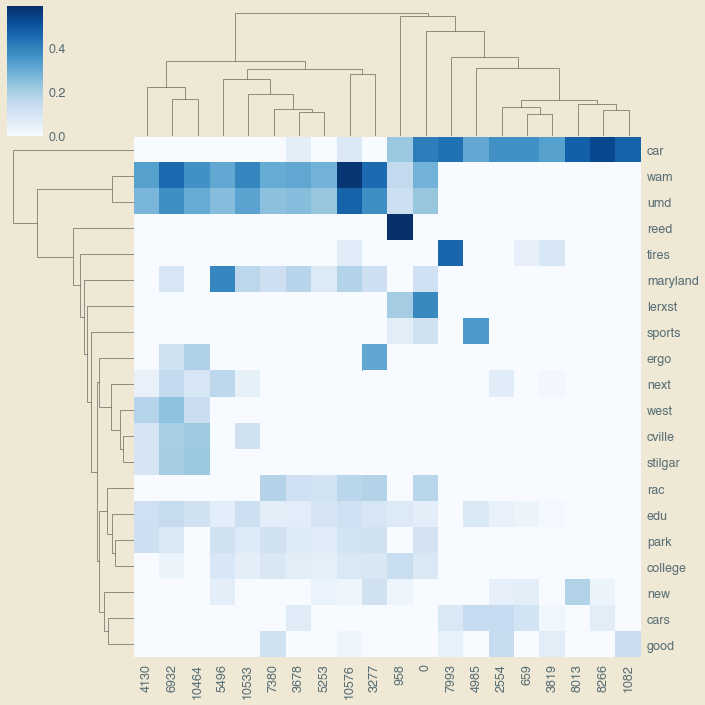

In [22]:
plt.figure(figsize=(20,8))
sns.clustermap(df_tfidf.fillna(0).T, cmap='Blues')

## Train a classifier using TFIDF

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [24]:
X = newsgroups.data
y = newsgroups.target

# Split into train and test set
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y)

In [25]:
vectorizer = TfidfVectorizer(preprocessor=stemmer.stem, stop_words=input_stopwords, min_df=2, 
                             max_df=0.9,
                            token_pattern=r"[a-zA-Z]{2,}")
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Train classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on test class
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# Show scores
print("accuracy", (y_pred == y_test).mean())
print('F1', f1_score(y_test, y_pred, average='weighted'))
print('recall', recall_score(y_test, y_pred, average='weighted'))
print('precision', precision_score(y_test, y_pred, average='weighted'))

accuracy 0.8469423824673029
F1 0.8454934852767634
recall 0.8469423824673029
precision 0.8536500645165409


Plot the confusion matrix

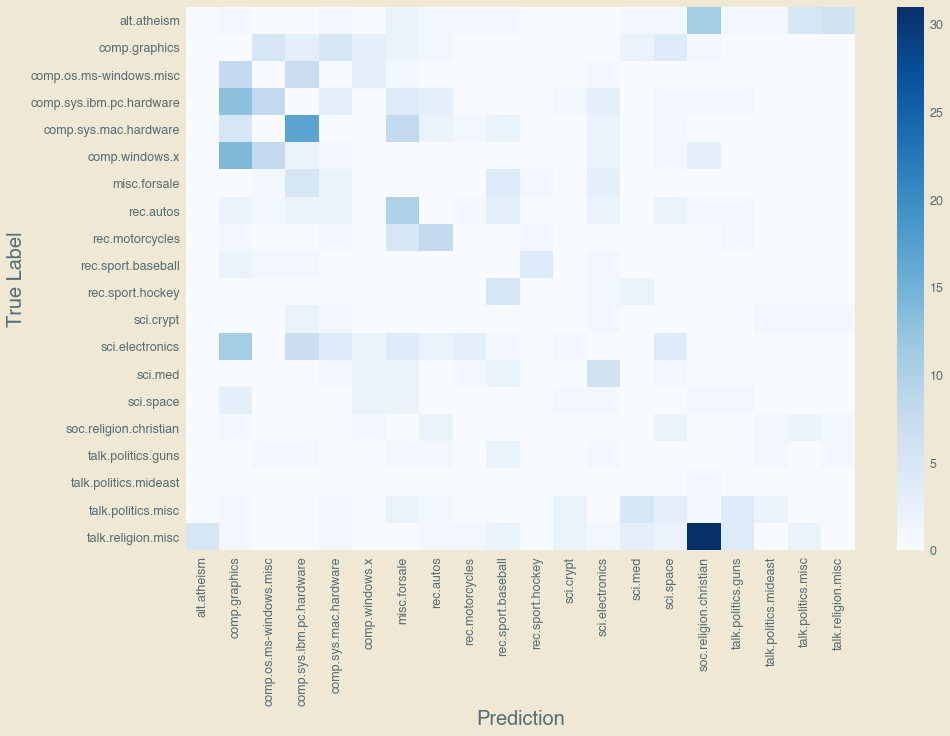

In [26]:
mat = confusion_matrix(y_test, y_pred) * (np.identity(len(newsgroups.target_names))!=1).astype(int)
mat = pd.DataFrame(data=mat, columns=newsgroups.target_names, index=newsgroups.target_names)
plt.figure(figsize=(15, 10))
sns.heatmap(mat, cmap='Blues')
plt.xlabel("Prediction", fontsize=20);
plt.ylabel("True Label", fontsize=20);

### We can also plot the vectors in a 2-D space

In [46]:
from sklearn.manifold import TSNE
target_names = {i:k for i, k in enumerate(newsgroups.target_names)}
x_plot = TSNE().fit_transform(X_test)
df_v = pd.DataFrame(x_plot, columns=['x','y'])
df_v['target'] = [target_names.get(x) for x in y_test]
df_v['pred'] = [target_names.get(x) for x in y_pred]

In [47]:
df_v.head()

,x,y,target,pred
0,-13.426824,9.467989,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware
1,5.348517,-42.748169,comp.sys.ibm.pc.hardware,comp.sys.ibm.pc.hardware
2,49.850338,31.386789,alt.atheism,alt.atheism
3,-28.125605,1.156664,comp.sys.mac.hardware,comp.sys.mac.hardware
4,44.419605,7.453356,talk.politics.misc,talk.politics.misc


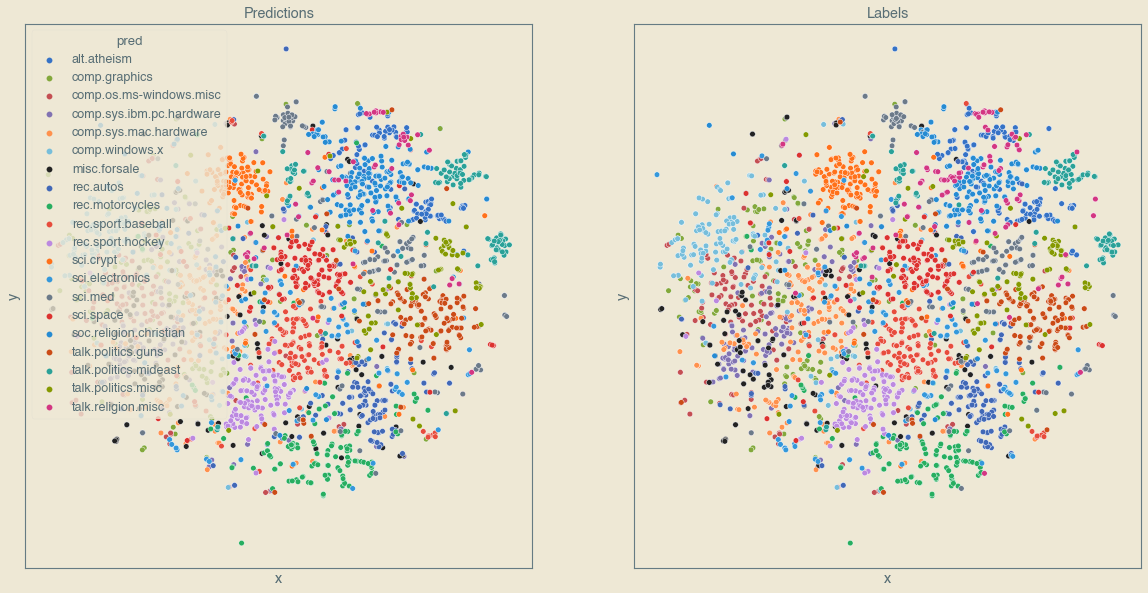

In [55]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.scatterplot(data=df_v.sort_values('pred'), x='x', y='y', hue='pred')
plt.title('Predictions');
plt.xticks([]); plt.yticks([]);
plt.subplot(122)
sns.scatterplot(data=df_v.sort_values('target'), x='x', y='y', hue='target', legend=None)
plt.title('Labels');
plt.xticks([]); plt.yticks([]);

# Word 2 vec

In [32]:
print(sentences)
vectors

['We will stick to natural language processing in this class', 'Bert found a stick in the forest']


[array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]),
 array([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0])]

<img src='https://miro.medium.com/max/1000/1*1O5gLhOg25HviI8bwZxV4g.png' > Source: https://mc.ai/deep-nlp-word-vectors-with-word2vec/

There are two types of W2V models, CBOW (Continuous Bag of Words) and Skip-gram
<img src="https://www.researchgate.net/profile/Daniel_Braun6/publication/326588219/figure/fig1/AS:652185784295425@1532504616288/Continuous-Bag-of-words-CBOW-CB-and-Skip-gram-SG-training-model-illustrations.png">

### CBOW 
The CBOW method, tries to predict the target word based on the context.

**We will <font color='red'>stick</font> to Natural <font color='gray'>language processing in this class**</font>

Average of context words:
('we', 'will' 'to', 'natural') -> 'stick'

**CBOW is faster and has slightly better accuracy for frequent words**

### Skip-gram

The skip-gram method tries to predict the context, based on the input word.

**<font color='red'>We will</font> stick <font color='red'>to Natural </font><font color='gray'>language processing in this class</font>**

Word 'stick' -> ('we', 'will' 'to', 'natural')

**Skip-gram works well with small datasets, and has better representation for rare words or phrases**

## Training a w2v model

A w2v model can easily be trained using the gensim package

In [33]:
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec

stem = SnowballStemmer('english')
sentok = PunktSentenceTokenizer()
tok = RegexpTokenizer(r"[a-zA-Z]{2,}")
sentences = [sentok.tokenize(x.lower()) for x in newsgroups.data]
sentences = [tok.tokenize(s) for sent in sentences for s in sent]
stemmed = [[stem.stem(s) for s in sent] for sent in sentences]

In [56]:
model = Word2Vec(sentences, min_count=5, sg=0, window=5)
model.wv.most_similar('computers', topn=10)

[('platforms', 0.8607274889945984),
 ('machines', 0.8510891199111938),
 ('packages', 0.829599916934967),
 ('workstations', 0.8101068139076233),
 ('applications', 0.8040137887001038),
 ('pcs', 0.7959615588188171),
 ('workstation', 0.7937494516372681),
 ('silicon', 0.7891894578933716),
 ('capabilities', 0.7720874547958374),
 ('models', 0.7720366716384888)]

In [57]:
model = Word2Vec(stemmed, min_count=5, sg=0, window=5)
model.wv.most_similar('comput', topn=10)

[('engin', 0.7261886596679688),
 ('network', 0.6091169118881226),
 ('research', 0.6016672849655151),
 ('tech', 0.596804678440094),
 ('system', 0.5861861705780029),
 ('electron', 0.5841708779335022),
 ('carnegi', 0.5837568044662476),
 ('academ', 0.5775421857833862),
 ('depart', 0.5755692720413208),
 ('centr', 0.5711894631385803)]

In [36]:
from sklearn.decomposition import PCA
words = ['research', 'space', 'medical']

N = 10
un_words = []
basew = []
for word in words:

    un_words.extend([x[0] for x in model.wv.most_similar(stem.stem(word), topn=N)])
    un_words.append(word)
    basew.extend([word for n in range(N+1)])

X = PCA(2).fit_transform(np.stack([model.wv[stem.stem(w)] for w in un_words]))
df = pd.DataFrame(X, columns=['x', 'y'])
df['word'] = un_words
df['baseword'] = basew


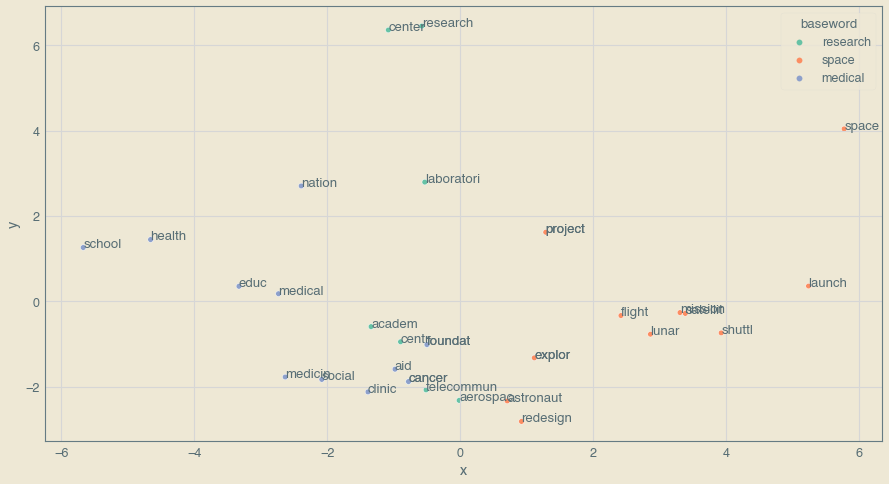

In [37]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='x', y='y', hue='baseword', palette='Set2')
for row in df.itertuples():
    plt.annotate(row.word, (row.x, row.y))

# Topic modelling

There are different ways of obtaining topics from a corpus.

- **Supervised**
    - Classification: Like the tfidf example we saw above. However this requires you to know the topics beforehand, and train a classifier to recognize them.
- **Semi-supervised**
    - Query: Using a vectorizer like the tfidf method, you can use similarity metrics to find documents close to a query
- **Unsupervised**
    - LDA: Unsupervised methods use propabilistic calculations to find common topics in text.

# LDA

<img src='https://miro.medium.com/max/1000/1*tmmF-dCMjvASOrGuwxJN9w.png'>
source: <a href='https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d'>https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d</a>

<img src='https://miro.medium.com/max/1000/1*f7ODdUPZtkcWUNcT0CJDzw.png'>
source: <a href='https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d'>https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d</a>

There are two main hypterparameters that are important in LDA.

**The alpha** Controls how many topics are in one document

> Turn it *down*, and the documents is more likely to have one or few topics. 

> Turn it *up*, and the documents will likely have more of a mixture of topics.

**The beta** (or eta in gensim) hyperparameter controls the distribution of words per topic. 

> Turn it *down*, and the topics will likely have less words. 

> Turn it *up*, and the topics will likely have more words.
   

In [38]:
from sklearn.decomposition import NMF
from gensim.models import LdaModel
from gensim.corpora import Dictionary

In [58]:
fake_documents = [['bread']*10, 
                  ['avocado']*10, 
                  ['bacon']*10, 
                  [*['bacon']*10, *['avocado']*10, *['bread']*10]]
dictionary = Dictionary(fake_documents)
corpus = [dictionary.doc2bow(doc) for doc in fake_documents]

lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=100, alpha=.33, eta=.01)
print(lda.print_topics(num_words=1),'\n')
for i, doc in enumerate(corpus):
    t1, t2, t3 = lda.get_document_topics(doc)
    print('Document', i)
    print(dictionary.id2token[t1[0]], np.round(t1[1], 2),
    dictionary.id2token[t2[0]], np.round(t2[1], 2),
    dictionary.id2token[t3[0]], np.round(t3[1], 2))

[(0, '0.500*"bread"'), (1, '0.999*"bacon"'), (2, '0.333*"bacon"')] 

Document 0
bread 0.94 avocado 0.03 bacon 0.03
Document 1
bread 0.94 avocado 0.03 bacon 0.03
Document 2
bread 0.03 avocado 0.94 bacon 0.03
Document 3
bread 0.66 avocado 0.33 bacon 0.01


### Let's try and run this on the newsgroups dataset

In [40]:
# Tokenize the text
tok = RegexpTokenizer(r"[a-zA-Z]{3,}")
documents = [tok.tokenize(text.lower()) for text in newsgroups.data]

#check to see we're keeping the right shape
assert len(documents) == len(newsgroups.data)

In [41]:
dictionary = Dictionary(documents)
dictionary.filter_extremes(no_above=.1, no_below=150)
stopword_ids = [dictionary.token2id.get(w, None) for w in input_stopwords]
dictionary.filter_tokens(bad_ids=stopword_ids)
corpus = [dictionary.doc2bow(doc) for doc in documents]
lda = LdaModel(corpus, id2word=dictionary, num_topics = len(target_names), passes=10, chunksize=200,
              alpha=.4, eta=.8)

In [42]:
for i in range(20):
    terms = np.array(lda.get_topic_terms(i, topn=8))
    print(f'Topic {i}')
    print('\t',' '.join([str(dictionary.id2token[t[0]]) + '('+str(np.round(t[1], 2))+')' for t in terms]))

Topic 0
	 day(0.02) ago(0.02) told(0.02) went(0.01) days(0.01) left(0.01) came(0.01) pitt(0.01)
Topic 1
	 tell(0.01) anything(0.01) bad(0.01) enough(0.01) little(0.01) maybe(0.01) give(0.01) lot(0.01)
Topic 2
	 david(0.08) john(0.06) org(0.05) mark(0.05) jim(0.04) robert(0.04) wrote(0.03) newsreader(0.03)
Topic 3
	 key(0.06) chip(0.04) netcom(0.04) clipper(0.03) encryption(0.03) keys(0.02) att(0.02) security(0.02)
Topic 4
	 year(0.08) washington(0.04) andrew(0.04) cmu(0.03) chicago(0.03) san(0.02) mot(0.02) york(0.02)
Topic 5
	 inc(0.06) opinions(0.04) steve(0.04) uucp(0.03) corporation(0.03) corp(0.02) disclaimer(0.02) mine(0.02)
Topic 6
	 space(0.07) gov(0.06) nasa(0.05) research(0.05) technology(0.04) institute(0.03) center(0.03) access(0.02)
Topic 7
	 evidence(0.02) however(0.01) science(0.01) example(0.01) given(0.01) claim(0.01) non(0.01) argument(0.01)
Topic 8
	 team(0.04) game(0.03) hockey(0.03) win(0.02) uiuc(0.02) games(0.02) play(0.02) toronto(0.02)
Topic 9
	 sun(0.03) infor

In [43]:
pred = []
for i, doc in enumerate(corpus):
    pred.append(pd.DataFrame(lda.get_document_topics(doc)).set_index(0).idxmax().values[0])

In [44]:
df = pd.DataFrame([pred, newsgroups.target]).T
df.columns = ['pred', 'label']
df['label'] = df['label'].replace(target_names)
df['count'] = 1
df.head()

,pred,label,count
0,11,rec.autos,1
1,4,comp.sys.mac.hardware,1
2,1,comp.sys.mac.hardware,1
3,2,comp.graphics,1
4,7,sci.space,1


<AxesSubplot:xlabel='pred', ylabel='count'>

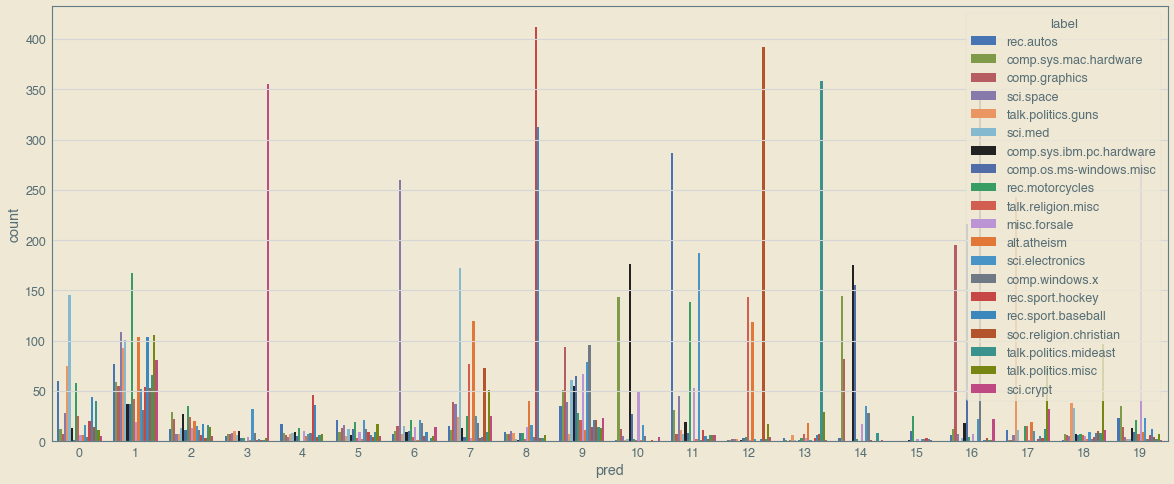

In [45]:
x, y = np.unique(pred, return_counts=True)
x2, y2 = np.unique(newsgroups.target, return_counts=True)
plt.figure(figsize=(20,8))
sns.barplot(data=df, y="count", x='pred', hue='label', estimator=sum)


# Exercise time

On datacamp, try **'Simple topic identification'** module.
If you have time left, take a look at the **Named-entity recognition** module